# Project 2: Topic Classification

W207  <br />
Class: Thursday 6:30-8 PDT <br />
Student: Clayton Leach

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

#Changed to .model_selection as sklearn moved things around
from sklearn.model_selection import GridSearchCV
#Including for Grid search (I know we aren't supposed to add packages!)
from sklearn.metrics import make_scorer, accuracy_score

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)


# Added round function to index selection as len(newsgroups_test) is odd
test_data, test_labels = newsgroups_test.data[int(round(num_test/2,0)):], \
                                            newsgroups_test.target[int(round(num_test/2,0)):]
dev_data, dev_labels = newsgroups_test.data[:int(round(num_test/2,0))], \
                                            newsgroups_test.target[:int(round(num_test/2,0))]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

# Set up list for future reference
trained_categories = newsgroups_train.target_names

print ('training label shape:', train_labels.shape)
print ('test data shape:', len(test_data))
print ('test label shape:', test_labels.shape)
print ('dev data shape:', len(dev_data))
print ('dev label shape:', dev_labels.shape)
print ('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test data shape: 677
test label shape: (677,)
dev data shape: 676
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

[2 pts]

In [3]:
def print_training_examples(examples, labels, label_key, num_examples=5):
    """
    Prints the top examples from the dataset, and reports the class
    :param examples: the list of examples
    :param labels: Actual labels which correspond to the examples
    :param label_key: List of classes which appropriately map to labels
    :param num_examples: Number of examples to display; default 5
    """
    for x in range(0,num_examples):
        print("Example %s is of type %s and reads:" % ((x+1),label_key[labels[x]]))
        print("")
        print(examples[x])
        print("*****************END EXAMPLE*****************************")
        print("")
    

print_training_examples(train_data, train_labels, trained_categories)


Example 1 is of type comp.graphics and reads:

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
*****************END EXAMPLE*****************************

Example 2 is of type talk.religion.misc and reads:



Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

[6 pts]

In [4]:
def vectorize_analysis(train_data, vocab = [], ngram_selection = (1,1),analyzer = 'word', min_doc_freq = 1):
    """
    Create a CountVectorizer object, and use it to create a feature matrix from raw text data
    :param train_data: raw text data in list form
    :param vocab: list of words which can be features; default not used
    :param ngram_selection: tuple to specify n-gram selections
    :param analyzer: specify unit the CountVectorizer should use when creating features; default "word"
    :param min_doc_freq: specify minimum number of documents a word must occur in to be included; default 1
    """
    if len(vocab) <1:
        vectorize = CountVectorizer(ngram_range=ngram_selection, analyzer=analyzer,
                                    min_df=min_doc_freq)
    else:
        vectorize = CountVectorizer(vocabulary = vocab, ngram_range=ngram_selection, analyzer=analyzer,
                                    min_df=min_doc_freq)
        
    features = vectorize.fit_transform(train_data)
    return features, vectorize

# Obtain our feature matrix and vectorize object with default settings on training data
train_feature_matrix, train_vectorize = vectorize_analysis(train_data)

# Part a
# Use .nnz, and .shape attributes to determine number of features, and non-zero features per example
print("The vocabulary length is equal to the number of columns, which is:",train_feature_matrix.shape[1])
print("The average non-zero values per example is equal to the total non-zero values divided by"
      "the number of examples: %s / %s = %s" %(train_feature_matrix.nnz,train_feature_matrix.shape[0],
                                               train_feature_matrix.nnz/train_feature_matrix.shape[0]))
print()


# Part b
feature_names = train_vectorize.get_feature_names()
alpha_feature_names = [feature for feature in feature_names if feature.isalpha()]
print("The first string is", feature_names[0])
print("The first string with only letters is",alpha_feature_names[0])
print("The last string is", feature_names[len(feature_names)-1])
print()


# Part c
vocab = ["atheism", "graphics", "space", "religion"]

# get vocab specific (vs) feature matrix and vectorizer object
vs_feature_matrix, vs_vectorize = vectorize_analysis(train_data, vocab=vocab)
print("The vocabulary length is equal to the number of columns, which is:",vs_feature_matrix.shape[1])
print("The average non-zero values per example is equal to the total non-zero values divided by"
      "the number of examples: %s / %s = %s" %(vs_feature_matrix.nnz,vs_feature_matrix.shape[0],
                                               vs_feature_matrix.nnz/vs_feature_matrix.shape[0]))
print()


# Part d
# Get feature matrix and vectorizer object including n-grams
for i in range(1,4):
    ng_feature_matrix, ng_vectorize = vectorize_analysis(train_data, ngram_selection=(1,i))
    print("Vocab length when we use combinations up to %s-grams is:" %i, ng_feature_matrix.shape[1])
print()
    
    
#Part e
# Get feature matrix and vectorizer object with pruning if word in less than 10 documents
pruned_feature_matrix, pruned_vectorize = vectorize_analysis(train_data, min_doc_freq=10)
print("The vocabulary length is equal to the number of columns, which is:",pruned_feature_matrix.shape[1])
print()

#Part f
# Calculate the vocabulary from the training and dev sets and find words in dev that aren't in training
dev_feature_matrix, dev_vectorize = vectorize_analysis(dev_data)
dev_dict = dev_vectorize.get_feature_names()
train_dict = train_vectorize.get_feature_names()
missing_dev_words = [word for word in dev_dict if word not in train_dict]
fraction_dev_missing = len(missing_dev_words)/len(dev_dict)
print("%s percent of the words in the dev vocab are not in the training vocab" %round((fraction_dev_missing*100),2))

The vocabulary length is equal to the number of columns, which is: 26879
The average non-zero values per example is equal to the total non-zero values divided bythe number of examples: 196700 / 2034 = 96.70599803343165

The first string is 00
The first string with only letters is aah
The last string is zyxel

The vocabulary length is equal to the number of columns, which is: 4
The average non-zero values per example is equal to the total non-zero values divided bythe number of examples: 546 / 2034 = 0.26843657817109146

Vocab length when we use combinations up to 1-grams is: 26879
Vocab length when we use combinations up to 2-grams is: 221770
Vocab length when we use combinations up to 3-grams is: 537462

The vocabulary length is equal to the number of columns, which is: 3064

24.79 percent of the words in the dev vocab are not in the training vocab


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

[4 pts]

In [5]:
def knn(k_value,features,labels,dev_features,dev_labels):
    """
    fit a knn model, and report model features on a dev set
    
    :param k_values: hyperparameter indicating number of neighbors for model to consider
    :param features: training feature set
    :param labels: training label set
    :param dev_features: dev feature set
    :param dev_labels: dev label set
    """
    
    knn_model = KNeighborsClassifier(n_neighbors=k_value)
    knn_model.fit(features,labels)
    
    #knn "score" is accuracy, so don't need to specify accuracy_score
    accuracy = knn_model.score(dev_features,dev_labels)
    
    return knn_model, accuracy


k=2
t_dev_matrix = train_vectorize.transform(dev_data)
knn_model, accuracy = knn(k,train_feature_matrix,train_labels,t_dev_matrix,dev_labels)

dev_predictions = knn_model.predict(t_dev_matrix)
knn_f1_score = metrics.f1_score(dev_labels,dev_predictions, average='micro')

print("The f1 score is %s" %(knn_f1_score))

The f1 score is 0.39644970414201186


In [6]:
def k_grid_search(k_values,scoring_method,test_features, test_labels):
    """
    Searches for optimal k value for a knn model and returns the 
    output from the GridSearchCV function
    
    :param k_values: list of k values to try
    :scoring_method: scoring method to be used in GridSearch
    """
    
    parameters = {'n_neighbors':k_values}
    scorer = make_scorer(scoring_method)
    knn_model = KNeighborsClassifier()
     
    best_k_finder = GridSearchCV(knn_model, parameters,
                                    scoring=scorer,return_train_score=True)
    gs_output = best_k_finder.fit(test_features, test_labels)
    return gs_output


k_vals = [x for x in range(1,11)]
best_knn = k_grid_search(k_vals, accuracy_score, train_feature_matrix, train_labels)
best_knn.cv_results_

/Users/clayleach/p3env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'mean_fit_time': array([0.00322398, 0.00362102, 0.00340501, 0.00393263, 0.00378521,
        0.00367554, 0.0035576 , 0.00371106, 0.00390124, 0.00360624]),
 'std_fit_time': array([0.00011793, 0.00025681, 0.00031393, 0.00018626, 0.00016906,
        0.0003961 , 0.00027999, 0.00030162, 0.00044798, 0.00041462]),
 'mean_score_time': array([0.06100877, 0.06268843, 0.06355596, 0.06897799, 0.06918653,
        0.0705781 , 0.07052668, 0.06860209, 0.06929676, 0.07002099]),
 'std_score_time': array([0.00189371, 0.00063885, 0.00062296, 0.00044781, 0.00080206,
        0.00222814, 0.00121859, 0.00073859, 0.00106854, 0.00128944]),
 'param_n_neighbors': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 1},
  {'n_neighbors': 2},
  {'n_neighbors': 3},
  {'n_neighbors': 4},
  {'n_neighbors': 5},
  {'n_neighbors': 6},


In [7]:
final_knn_model = KNeighborsClassifier(n_neighbors=10).fit(train_feature_matrix, train_labels)

In [8]:
best_knn.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')

The optimal value of k appears to be 10 based on the mean test results.  Note: Higher values might improve, but 
I only tested values from 1-10.

Part a: KNN doesn't work well for this problem because so little of our space is actually covered.  Space grows exponentially as you add dimensions (e.g. if you assume any dimension can go from 0-100 in integers, then going from 1 dimension to 2 dimensions increases possible combinations from 100, to 100^2) and our feature space is over 10,000.  At this size we would need an absolutely monsterous corpus of texts (maybe larger than exists?) in order to realistically expect new examples to have neighbors that are in fact "near".

In [9]:
def mnb_grid_search(alphas,scoring_method,features, labels):
    """
    Searches for optimal k value for a knn model and returns the 
    output from the GridSearchCV function
    
    :param k_values: list of k values to try
    :scoring_method: scoring method to be used in GridSearch
    """
    
    parameters = {'alpha':alphas}
    scorer = make_scorer(scoring_method)
    mnb_model = MultinomialNB()
     
    best_mnb_finder = GridSearchCV(mnb_model, parameters,
                                    scoring=scorer,return_train_score=True)
    gs_output = best_mnb_finder.fit(features, labels)
    return gs_output


alphas = [x/10 for x in range(0,10)]
best_mnb = mnb_grid_search(alphas, accuracy_score, train_feature_matrix, train_labels)
best_mnb.cv_results_

/Users/clayleach/p3env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/clayleach/p3env/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/clayleach/p3env/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/clayleach/p3env/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


{'mean_fit_time': array([0.0067927 , 0.00567706, 0.00502419, 0.00518386, 0.00526134,
        0.00572737, 0.00581598, 0.00571593, 0.0058976 , 0.00598057]),
 'std_fit_time': array([0.00075528, 0.00037351, 0.00012989, 0.0002219 , 0.00041359,
        0.00049209, 0.00037153, 0.00047641, 0.00047483, 0.00099798]),
 'mean_score_time': array([0.00117588, 0.000935  , 0.00087945, 0.00093857, 0.00088398,
        0.00102496, 0.00100493, 0.00097537, 0.00099866, 0.00090599]),
 'std_score_time': array([1.28806212e-04, 1.87269493e-05, 2.73882892e-05, 8.07776627e-05,
        2.48309132e-05, 3.74673868e-05, 5.84590817e-05, 4.49851487e-05,
        7.04429963e-05, 1.39849654e-05]),
 'param_alpha': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.0},
  {'alpha': 0.1},
  {'alpha': 0.2},
  {'alpha': 0.3},

In [10]:
final_mnb_model = MultinomialNB(alpha=.1).fit(train_feature_matrix,train_labels)

In [11]:
best_mnb.best_estimator_

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

The best value of alpha appears to be .1, indicating that smoothing helps initially but the marginal return drops quickly and becomes negative as smoothing increases.

In [12]:
def logistic_regression_gs(c_values, scoring_method, features, labels):
    """
    Searches for optimal C value (regularization parameter)
    
    :param c_values: list of c_values to try
    :param scoring_method: how the best paramters should be determined
    :param features: feature matrix for grid search to use
    :param labels: labels which correspond to the feature matrix
    """
    
    # Default is L2 regularization so no need to specify
    parameters = {'C': c_values}
    scorer = make_scorer(scoring_method)
    lr_model = LogisticRegression()
     
    best_lr_finder = GridSearchCV(lr_model, parameters,
                                    scoring=scorer,return_train_score=True)
    gs_output = best_lr_finder.fit(features, labels)
    return gs_output

# First ran without dividing by 100 to determine integer range.  Then narrowed 
# scope to be more precise
c_values = [x/100 for x in range(1,101)]
best_lr = logistic_regression_gs(c_values, accuracy_score, train_feature_matrix,train_labels)

best_lr.cv_results_

/Users/clayleach/p3env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/clayleach/p3env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/clayleach/p3env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


{'mean_fit_time': array([0.14874021, 0.17398198, 0.19290471, 0.20373011, 0.20353436,
        0.21886325, 0.22747183, 0.23086365, 0.23345343, 0.2435027 ,
        0.23904808, 0.24736969, 0.25277766, 0.25087825, 0.27498905,
        0.28238463, 0.27490664, 0.28828359, 0.27836792, 0.25990407,
        0.27502577, 0.28659463, 0.27746352, 0.29288809, 0.27376835,
        0.30181909, 0.29200641, 0.30742598, 0.29359492, 0.28408424,
        0.29597092, 0.33397659, 0.31869078, 0.32748453, 0.31643629,
        0.29999606, 0.31225459, 0.33165081, 0.36729868, 0.31098533,
        0.34370867, 0.31808233, 0.32863506, 0.3298889 , 0.33546011,
        0.32552401, 0.33919891, 0.32686234, 0.33718363, 0.31158527,
        0.34532007, 0.3583103 , 0.34677935, 0.35582431, 0.35512074,
        0.3277456 , 0.35190034, 0.36129642, 0.33436934, 0.34137201,
        0.33225179, 0.34049741, 0.34449363, 0.37118657, 0.36019238,
        0.36889029, 0.35372138, 0.37083205, 0.33803233, 0.33665101,
        0.37519439, 0.36295001,

In [13]:
best_lr.best_estimator_

LogisticRegression(C=0.17, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [14]:
final_lr_model = LogisticRegression(C=.17)
final_lr_model.fit(train_feature_matrix,train_labels)

LogisticRegression(C=0.17, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

The best value of C using l2 regularization appears to be .17

In [15]:
def weight_vector_squared_cvals(cvals,train_features,train_labels):
    """
    Trains a logistic regression model for each C value in cvals and displays squared sum of weights
    
    :param cvals: list of c values to loop through
    :param train_features: feature matrix to use for training logistic regression models
    :param train_labels: labels which correspond to feature matrix 
    """
    for c in cvals:
        lr_model = LogisticRegression(C=c)
        lr_model.fit(train_features,train_labels)
        print("The sum of the squared class weights for a c value of %s are:" %c)
        for class_weights in lr_model.coef_:
            sum_squared_weights = sum([x**2 for x in class_weights])
            print(sum_squared_weights)
        print()
    return

# Constraining values of C to be between 0.01 and .30, which contains the best known value of .17
cvals=[x/100 for x in range(1,31)]
weight_vector_squared_cvals(cvals,train_feature_matrix,train_labels)
        

The sum of the squared class weights for a c value of 0.01 are:
2.5414876825471953
2.939709368355681
2.86246910168806
2.2500291895155713

The sum of the squared class weights for a c value of 0.02 are:
5.470520942796796
5.876203158183534
5.940956333135873
4.668471255607357

The sum of the squared class weights for a c value of 0.03 are:
8.39880635722094
8.618776320052232
8.92626253861162
7.097739339166522

The sum of the squared class weights for a c value of 0.04 are:
11.269459032462805
11.206098478396415
11.810370484636975
9.497115200048356

The sum of the squared class weights for a c value of 0.05 are:
14.073249976030867
13.670525807868028
14.604524709767155
11.860679431957669

The sum of the squared class weights for a c value of 0.06 are:
16.806962305340676
16.02604580886329
17.31408406639881
14.178196626109594

The sum of the squared class weights for a c value of 0.07 are:
19.477309208771377
18.30326472286127
19.94975712075102
16.454469500295964

The sum of the squared class we

Part b: Our training data only contains approx. 2000 examples, and therefore logistic regression might be overfitting.  Naive Bayes can outperform logistic regression when the training set is small. 

Part C: As seen above, as C increases the sum of the squared weights also increase. C is a regularization term which seeks to penalize large weights in an attempt to avoid overfitting; SKlearn defines the parameter C as the inverse of the regularization strength, so higher values of C actually correspond to less strigent regularization, explaining the relationship we see.

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

[5 pts]

In [16]:
# Only using for display purposes
import pandas as pd

def find_important_features(lr_model, feature_map):
    """
    Finds the top 5 predictive terms for each of the 4 classes
    
    :param lr_model: a 4 class logistic regression model
    :param feature_map: Dictionary with keys being index in feature map and values being actual term
    """
    
    final_index_list = []
    for weight_vector in lr_model.coef_:
        sorted_index = sorted(range(len(weight_vector)), key=lambda i: weight_vector[i])
        top_five = sorted_index[-5:]
        for val in top_five:
            final_index_list.append(val)
    all_rows = []
    for feature in final_index_list:
        row = [feature_map[feature],lr_model.coef_[0][feature],lr_model.coef_[1][feature],
               lr_model.coef_[2][feature],lr_model.coef_[3][feature]]
        all_rows.append(row)
        
    feature_df = pd.DataFrame(columns=['feature_name','alt.atheism weight','comp.graphics weight',
                                       'sci.space weight','talk.religion.misc weight'])
    for row in all_rows:
        feature_df = feature_df.append({'feature_name':row[0],'alt.atheism weight':row[1],
                                        'comp.graphics weight':row[2],'sci.space weight':row[3],
                                        'talk.religion.misc weight':row[4]}, ignore_index=True)
        
    return feature_df


reordered_feature_map = {}
for k,v in train_vectorize.vocabulary_.items():
    reordered_feature_map[v] = k

# final_lr_model is trained from above
features_df = find_important_features(final_lr_model, reordered_feature_map)
features_df.head(20)

,feature_name,alt.atheism weight,comp.graphics weight,sci.space weight,talk.religion.misc weight
0,islam,0.503542,-0.092044,-0.201130,-0.202565
1,atheists,0.570050,-0.085481,-0.191737,-0.388185
2,bobby,0.585220,-0.143682,-0.204621,-0.277212
3,religion,0.585707,-0.360907,-0.473869,-0.013792
4,atheism,0.586168,-0.252848,-0.249885,-0.301943
5,computer,-0.014714,0.650749,-0.402976,-0.277517
6,3d,-0.219877,0.670775,-0.388885,-0.224038
7,file,-0.204794,0.767295,-0.502746,-0.351597
8,image,-0.322263,0.786370,-0.457738,-0.264161
9,graphics,-0.480783,1.194508,-0.785010,-0.446550


In [17]:
# Reuse previous function but with ngram_selection specified to include bigrams
train_feature_matrix_bigrams, train_vectorize_bigrams = vectorize_analysis(train_data,ngram_selection=(1,2))

reordered_feature_map = {}
for k,v in train_vectorize_bigrams.vocabulary_.items():
    reordered_feature_map[v] = k

bg_lr_model = LogisticRegression(C=.17)
bg_lr_model.fit(train_feature_matrix_bigrams, train_labels)

# Use find_important_features function to determine most imporant features from our bigram model
features_df = find_important_features(bg_lr_model, reordered_feature_map)
features_df.head(20)

/Users/clayleach/p3env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/clayleach/p3env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


,feature_name,alt.atheism weight,comp.graphics weight,sci.space weight,talk.religion.misc weight
0,islam,0.377270,-0.070834,-0.137765,-0.155879
1,bobby,0.383349,-0.106608,-0.134700,-0.183435
2,atheists,0.384934,-0.074460,-0.127726,-0.228545
3,atheism,0.438171,-0.172129,-0.174991,-0.200170
4,religion,0.495610,-0.273505,-0.345752,0.007270
5,files,-0.268052,0.468104,-0.195601,-0.279519
6,3d,-0.159121,0.494683,-0.290063,-0.160874
7,image,-0.242849,0.605323,-0.340289,-0.217890
8,file,-0.172596,0.618205,-0.403550,-0.278058
9,graphics,-0.381259,0.985361,-0.632260,-0.353172


Surprisingly no bigram made it into our top 20.  This does make some sense however, since there are most likely very few repeated bigrams, whereas a class is more likely to share individual words when the classes are distinct topics. 

There were a few differences among the lists.  "Files" in the first list was replaced was "File", and "blood" was replaced by "koresh".  This indicates that blood as an individual word lost some of its significance which would have been spread out over the various bigrams which included blood. 

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

In [18]:
# In a production setting where other packages are allowed might try the following:
#     1) Compare words to english dictionary; If word is not real use levenstein distance to real words and convert
#     2) Use nltk stemming packages to help implement all of various grammar rules

def nospace(match):
    return match.group(0).replace(" ","")

def no_plural_simple(match):
    if len(match.group(0))>3:
        return match.group(0)[:-1]
    else:
        return match.group(0)

def no_ally(match):
    return match.group(0).replace("ly","")

def no_number_letters(match):
    return " " + match.group(0)

def no_letter_number(match):
    return " " + match.group(0)

def no_ing(match):
    if len(match.group(0)) >5:
        return match.group(0)[:-3]
    else:
        return match.group(0)


def preprocess_data(s):
    # Lowercase everything
    s = s.lower()

    # Replace apostrophes to avoid possesives
    s = s.replace("'","")
    
    # Replace underscores to split into multiple words
    s = s.replace("_","")
    
    # Replace number sequences with a single joined number
    s = re.sub(r'(?<=\s)\d[0-9\s]+\d(?=\s[a-zA-Z])',nospace, s)
    
    # Doesn't cover every plural but does cover a good portion.  Does cause 
    # interpretability issue as word like "does" becomes "doe".
    s = re.sub(r'(?<=\s)[a-zA-Z]+(?<=[^aious])s\b',no_plural_simple,s)
    
    # Acknowledge this isn't perfect (e.g. specifically becomes specifical)
    s = re.sub(r'(?<=\s)[a-zA-Z]+ally',no_ally,s)
    
    # Make sure that things like 3jpg 7jpg are aknowledged as referencing jpg
    s = re.sub(r'(?<=\d)[a-zA-Z]+',no_number_letters,s)
    
    # Make sure that things like jpg3 jpg7 are aknowledged as referencing jpg
    s = re.sub(r'(?<=[a-zA[Z])\d',no_letter_number,s)
    
    # Try to stem words like "playing" to their root
    s = re.sub(r'(?<=\s)[a-zA-Z]+ing',no_ing,s)
    
    
    return s

preprocess_vectorize = CountVectorizer(preprocessor=preprocess_data)
features = preprocess_vectorize.fit_transform(train_data)
dev_features = preprocess_vectorize.transform(dev_data)

new_lr_model = LogisticRegression(C=.17)
new_lr_model.fit(features,train_labels)
accuracy = new_lr_model.score(dev_features,dev_labels)
print("The accuracy of this model is %s" %accuracy)
print("We were able to reduce the vocabulary count from %s to %s for a difference of %s"
     %(train_feature_matrix.shape[1],features.shape[1],train_feature_matrix.shape[1]-features.shape[1]))

The accuracy of this model is 0.7189349112426036
We were able to reduce the vocabulary count from 26879 to 23328 for a difference of 3551


In [19]:
baseline_dev_acc = LogisticRegression(C=.17).fit(train_feature_matrix,train_labels).\
                                        score(train_vectorize.transform(dev_data),dev_labels)
print("Our baseline dev accuracy is %s" %baseline_dev_acc)

Our baseline dev accuracy is 0.7144970414201184


The steps we took improved the dev accuracy by .0044, or an incremental gain of .6%.  This isn't drastic improvement, but does represent an incremental step in the right direction!

(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]

In [23]:
def lr_L1(train_features, train_labels, penalty='l1', c_val = 1):
    """
    Function to train a logistic regression model specifying a penalty of L1 and a C value of 1
    """
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)
    lr_model = LogisticRegression(penalty=penalty,C = c_val, tol=.01)
    lr_model.fit(train_features, train_labels)
    
    return lr_model

# Train two logistic regression models using our training feature matrix, one using L1
# regularization and the other L2
lr_model_L1 = lr_L1(train_feature_matrix, train_labels)
lr_model_L2 = lr_L1(train_feature_matrix, train_labels, penalty = 'l2')

In [24]:
def find_nonzero_features(mc_model):
    """
    Loops through each logistic regression model in a multiclass predictor and returns a list with the 
    indices of all weights which were non-zero
    
    :param mc_model: multi-class logistic regression model
    """
    non_zero_index = []
    for lr_model in mc_model.coef_:
        for index, value in enumerate(lr_model):
            if value>0:
                non_zero_index.append(index)
            else:
                pass
    return non_zero_index

# Find all non-zero weights and remove duplciates
non_zero_weights_L1 = find_nonzero_features(lr_model_L1)
non_zero_weights_L1 = list(set(non_zero_weights_L1))

non_zero_weights_L2 = find_nonzero_features(lr_model_L2)
non_zero_weights_L2 = list(set(non_zero_weights_L2))

# Get actual vocabulary which corresponds to the non-zero weights
L1_vocab = [k for (k,v) in train_vectorize.vocabulary_.items() if v in non_zero_weights_L1]
L2_vocab = [k for (k,v) in train_vectorize.vocabulary_.items() if v in non_zero_weights_L2]

print("The difference in the length of the L2 effective vocab list (words with non-zero weights) and the "
      "L1 effective vocab list is %s"% (len(L2_vocab)-len(L1_vocab)))

The difference in the length of the L2 effective vocab list (words with non-zero weights) and the L1 effective vocab list is 25673


In [25]:
# Create new feature matrix by limiting the vocab to our previously defined L1_vocab
L1_feature_matrix, L1_vectorize = vectorize_analysis(train_data, vocab = L1_vocab)

# Create a new logistic regression model using our L1_feature_matrix, but with L2 regulariation
lr_model_L1_vocab = lr_L1(L1_feature_matrix, train_labels, penalty = 'l2')

# Transform dev data and then calculate dev accuracy
L1_dev_feature_matrix = L1_vectorize.transform(dev_data)
print(lr_model_L1_vocab.score(L1_dev_feature_matrix,dev_labels))

0.6967455621301775


In [26]:
def c_vs_accuracy(train_matrix, train_labels, raw_train_data, raw_dev_data, dev_labels, c_vals):
    """
    For each c value train a lgostici regression model using L1 regularization.  Find only the terms
    which have non-zero weights and use that new vocab to train a logistic regression model with 
    L2 regularization.  Then use this model and calculate accuracy on dev data
    
    :param train_matrix: feature matrix for training
    :param train_labels: labels which correspond to train_matrix
    :raw_train_data: raw text data which was used to produce train_matrix
    :raw_dev_data: raw text data for dev set
    :dev_labels: class specifications corresponding to raw_dev_data
    :c_vals: list of values to be used for C
    """
    results = []
    for c_val in c_vals:
        lr_model_L1 = lr_L1(train_matrix, train_labels, c_val = c_val)

        non_zero_weights_L1 = find_nonzero_features(lr_model_L1)
        non_zero_weights_L1 = list(set(non_zero_weights_L1))
        L1_vocab = [k for (k,v) in train_vectorize.vocabulary_.items() if v in non_zero_weights_L1]

        feature_matrix, vectorize = vectorize_analysis(raw_train_data, vocab = L1_vocab)
        L2_model_L1_vocab = lr_L1(feature_matrix, train_labels, c_val = c_val, penalty = 'l2')
        dev_feature_matrix = vectorize.transform(raw_dev_data)
        acc = L2_model_L1_vocab.score(dev_feature_matrix,dev_labels)
        v_len = len(L1_vocab)
        results.append((acc,v_len))
    return results
c_values = [.01,.02,.03,.04,.05,.1,.15,.2,.25,.5,.75,1,2,3,4,5]
results = c_vs_accuracy(train_feature_matrix, train_labels, train_data, dev_data, dev_labels, c_values)

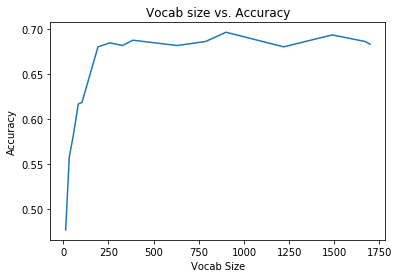

In [27]:
x_vals = []
y_vals = []
for result in results:
    # Add the vocab size to the list of x values and accuracy to list of y values
    x_vals.append(result[1])
    y_vals.append(result[0])
    
# Plot our vocab size vs dev accuracy
plt.plot(x_vals,y_vals)
plt.xlabel("Vocab Size")
plt.ylabel("Accuracy")
plt.title("Vocab size vs. Accuracy")
plt.show()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

[4 pts]

In [28]:
def tfidf_vectorize_analysis(train_data, vocab=[], ngram_selection = (1,1), analyzer = 'word', min_doc_freq=1):
    if len(vocab) <1:
        vectorize = TfidfVectorizer(ngram_range=ngram_selection, analyzer=analyzer,
                                    min_df=min_doc_freq)
    else:
        vectorize = TfidfVectorizer(vocabulary=vocab, ngram_range=ngram_selection, analyzer=analyzer,
                                   min_df=min_doc_freq)
        
    features = vectorize.fit_transform(train_data)
    
    return features, vectorize



TfidVectorizer is different from CountVectorizer in that it attempts to account for the fact that by nature longer documents will have more words, and that not all words carry equal information.  It stands for term frequency inverse document frequency, and is calculated as the term frequency multiplied by log(Total documents/Documents with term t).

In [29]:
# create feature matrix using tfidf weighting
tfidf_train_features, tfidf_train_vectorize = tfidf_vectorize_analysis(train_data,ngram_selection = (1,1))
tfidf_lr_model = LogisticRegression(C=100)
tfidf_lr_model.fit(tfidf_train_features,train_labels)

# Use tfidfVectorize object to transform raw dev_data into feature matrix
tfidf_dev_features = tfidf_train_vectorize.transform(dev_data)
tfidf_dev_predictions = tfidf_lr_model.predict_proba(tfidf_dev_features)

def calculate_r(prob_predictions, dev_labels):
    """
    Calculate "r" which is equal to max predicted probability divided by probability of correct class
    
    :param prob_predictions: predictions which contain probability for each class
    :param dev_labels: correct labels which correspond to predictions
    """
    r_vals = []
    counter = 0
    for prediction in prob_predictions:
        max_prob = max(prediction)
        pred_prob_correct_class = prediction[dev_labels[counter]]
        r = max_prob/pred_prob_correct_class
        map_tup = (r,counter)
        r_vals.append(map_tup)
        counter += 1
    return r_vals


r_vals = calculate_r(tfidf_dev_predictions, dev_labels)
r_vals.sort(reverse=True)
top3 = r_vals[0:3]

for example in top3:
    print("The correct class was %s" %trained_categories[dev_labels[example[1]]])
    print("The predicted class was %s" %trained_categories[tfidf_dev_predictions[example[1]].argmax()])
    print(dev_data[example[1]])
    print("****************END EXAMPLE***************************")

The correct class was talk.religion.misc
The predicted class was comp.graphics
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), but may not charge
anything for their time in making copies, or in any way realize a profit
from the use of this book.

ANSWER: For our first 2 examples we are predicting comp.graphics when the correct class is talk.religion.misc.  In both of these examples the text is discussing the "Book of Mormon" which is one of the holy books of the Mormon religion.  However, they are discussing an online version available via FTP, and as such use many words that are associated with computers/internet/etc.  The model is detecting this and predicting that this relates to comp.graphics, since this is the only computer category we included.

One approach to fix this might be to include bigrams.  My thinking is that this will help distinguish between cases where a word has a different meaning dependent on what comes before or after it.  To determine if this change helps I will measure both the sum of the r values (lower bound = num_examples * 1) as well as the number of correct predictions.

Another approach might be to oversample from examples which pertain to certain topics which we believe to be underrepresented.  For instance, Mormonism is likely to be mentioned less frequently than other religions, and therefore the model doesn't have enough data to know that this word should be just as indiciative of class as words like "Christianity".

In [30]:
# Results for baseline
r_sum= 0 
correct_count = 0
for example in r_vals:
    r_sum += example[0]
    if example[0] == 1:
        correct_count += 1
print(r_sum)
print(correct_count)

4226.650371995895
516


In [31]:
tfidf_train_features, tfidf_train_vectorize = tfidf_vectorize_analysis(train_data,ngram_selection = (1,2))
tfidf_lr_model = LogisticRegression(C=100)
tfidf_lr_model.fit(tfidf_train_features,train_labels)
tfidf_dev_features = tfidf_train_vectorize.transform(dev_data)
tfidf_dev_predictions = tfidf_lr_model.predict_proba(tfidf_dev_features)

def calculate_r(prob_predictions, dev_labels):
    r_vals = []
    counter = 0
    for prediction in prob_predictions:
        max_prob = max(prediction)
        pred_prob_correct_class = prediction[dev_labels[counter]]
        r = max_prob/pred_prob_correct_class
        map_tup = (r,counter)
        r_vals.append(map_tup)
        counter += 1
    return r_vals


r_vals = calculate_r(tfidf_dev_predictions, dev_labels)
r_vals.sort(reverse=True)
top3 = r_vals[0:3]

In [32]:
# Results when bigrams included
r_sum= 0 
correct_count = 0
for example in r_vals:
    r_sum += example[0]
    if example[0] == 1:
        correct_count += 1
print(r_sum)
print(correct_count)

2721.9781521774676
519


By including bigrams we were able to reduce the sum of the r values significantly, while marginally improving our accuracy. 

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance

In [33]:
mormon_list = []
label_list = []
for x in range(0,len(train_data)):
    if "mormon" in train_data[x].lower():
        mormon_list.append(train_data[x])
        label_list.append(train_labels[x])

In [34]:
oversampled_train_data = train_data + mormon_list
oversampled_label_list = np.append(train_labels,label_list)

In [35]:
tfidf_train_features, tfidf_train_vectorize = tfidf_vectorize_analysis(oversampled_train_data,ngram_selection = (1,2))
tfidf_lr_model = LogisticRegression(C=100)
tfidf_lr_model.fit(tfidf_train_features,oversampled_label_list)
tfidf_dev_features = tfidf_train_vectorize.transform(dev_data)
tfidf_dev_predictions = tfidf_lr_model.predict_proba(tfidf_dev_features)

def calculate_r(prob_predictions, dev_labels):
    r_vals = []
    counter = 0
    for prediction in prob_predictions:
        max_prob = max(prediction)
        pred_prob_correct_class = prediction[dev_labels[counter]]
        r = max_prob/pred_prob_correct_class
        map_tup = (r,counter)
        r_vals.append(map_tup)
        counter += 1
    return r_vals


r_vals = calculate_r(tfidf_dev_predictions, dev_labels)
r_vals.sort(reverse=True)
top3 = r_vals[0:3]

In [36]:
# Results when examples mentioning "mormon" are oversampled
r_sum= 0 
correct_count = 0
for example in r_vals:
    r_sum += example[0]
    if example[0] == 1:
        correct_count += 1
print(r_sum)
print(correct_count)

2785.9690265228814
518


Unfortunately this approach did not have the intended result as some of the original examples with high r values are still present.  